# Input Data & Equivariances

Molecular graphs and structures (xyz coordinates) are the fundamental features in molecules and materials. As discussed, often these are converted into *molecular descriptors* or some other representation. Why is that? Why can we not work with the data directly? For example, let's say we have a butane molecule and would like to predict its potential energy from its position. You could train a linear model $\hat{E}$ that predicts energy

\begin{equation}
    \hat{E} = \textbf{X}\textbf{W} + b
\end{equation}

where $\textbf{X}$ is $14$ (atoms) $\times$ $3$ (xyz coordinates) matrix containing positions and $\textbf{W}, b$ are trainable parameters. So far, this is all reasonable. Now what if I translate all the coordinates by -10:

\begin{equation}
\left(\textbf{X} - 10\right)\textbf{W} + b = \textbf{X} + b - 10 |\textbf{W}|
\end{equation}

We know the energy should not change if we translate all the coordinates equally -- the molecule is not changing conformations. However, our linear regression will change by $ - 10 |\textbf{W}|$. We have accidentally made our model sensitive to the origin of our coordinate system, which is not physical. This is **translational variance** -- our model changes when we translate the coordinates.

Consider another example from our butane molecule. What if we swapped the order of the atoms in our $\textbf{X}$ matrix. There is no such thing as a "left" or "right" side of our molecule, so it should not matter. However, you'll see that changing the order of $\textbf{X}$ changes which weights are multiplied and thus the predicted energy will change. This is called a **permutation variance**. Our model changes if we re-order or inputs, even though from our knowledge of chemistry this should not matter. Similarly, our output energy should not be sensitive to a rotation of the molecular coordinates. 

```{margin}
You could teach your model to learn permutation variance of left/right in this example, either by making your training data contain multiple orderings of $\textbf{X}$ or somehow making your $\textbf{W}$ be symmetric. You can accomplish this via data augmentation. However, this is inefficient because the number of permutations you want to train the model to ignore is combinatorially large. 
```

## Equivariances 
Models that work with molecules must be permutation equivariant. Permutation equivariant means that if you rearrange the order of atoms, the output changes in the same way. For example, if you're predicting partial charge per atom $\vec{y} = f(\textbf{X})$ and you rearrange $\textbf{X}$, you expect the $\vec{y}$ to rearrange to match that. Let's try to state this with an equation. Consider $\mathcal{P}_{34}$ to be the *permutation operator*. It swaps indices 3 and 4 in axis 0 of a tensor. Then a permutation equivariant model equation should have:


\begin{equation}
    f\left(\mathcal{P}_{ij}\left[\textbf{X}\right]\right) = \mathcal{P}_{ij}\left[\vec{y}\right], \quad \forall i,j
\end{equation}

where $i,j$ are indices of $\textbf{X}$ (atom indices). This is a bit of a narrow definition, you can find a more general form in {cite}`thomas2018tensor`. Now what happens if we output a scalar like energy? Then our permutation operator does nothing:


\begin{equation}
    f\left(\mathcal{P}_{ij}\left[\textbf{X}\right]\right) = \mathcal{P}_{ij}\left[\hat{E}\right] = \hat{E}
\end{equation}

we call this case a **permutation invariance**.

```{margin}
The classic way to introduce equivariance is through group theory. Rather than teach group theory here, I'll use simpler equations that do not quite fully capture the ideas and power of equivariances but get the point across quickly. 
```

```{note}
An invariance is special type of equivariance. If something is equivariant, you can easily make it invariant (e.g., averaging over your equivariant axes). 
```

## Equivariances of Coordinates

When we work with molecular coordinates as features we need to be a bit more careful in distinguishing between the "features" that might be element identity and those which specify the location in space. This kind of data is referred to as **point clouds** in computer science. Let's break our features into $(\vec{r}, \vec{x})$ where $\vec{r}$ is the location of the atom/point and $\vec{x}$ are its features (e.g., element, charge, spin, etc.). Similarly, we may have labels at each point so that we write our labels as $(\vec{r}', \vec{y})$. The label might be direction $\vec{r}'$ and force magnitude $y$ or perhaps a field at $\vec{r}'$ with vectors $\vec{y}$. You may not have $\vec{r}'$ like if you're predicting energy. It may be that $\vec{r} = \vec{r}'$. With this notation, we can write out **translation equivariance** as:

\begin{equation}
    f\left(\vec{r} + \vec{t}, \vec{x}\right) = (\vec{r}' + \vec{t}, \vec{y}), \quad  \forall\vec{t}
\end{equation}

You can also write this out if you have a matrix of atom positions (like a molecule):

\begin{equation}
    f\left(\textbf{R} + \vec{t}, \textbf{X}\right) = (\textbf{R}' + \vec{t}, \vec{y}_i), \quad  \forall\vec{t}
\end{equation}

In the case that you do not have output coordinates $\vec{r}'$, then it becomes:

\begin{equation}
    f\left(\textbf{R} + \vec{t}, \textbf{X}\right) = \vec{y}_i, \quad  \forall\vec{t}
\end{equation}

which we call **translation invariance.** It's important to note that these equations do not apply to some specific $\vec{t}$, but any $\vec{t}$. 


**Rotational equivariance** can be similarly defined. Consider $\mathcal{R}$ to be a rotation operator (e.g., a quaternion). Then our rotation equivariance equation is 

\begin{equation}
    f\left(\mathcal{R}\left[\textbf{R}\right], \textbf{X}\right) = (\mathcal{R}\left[\textbf{R}'\right], \vec{y}_i), \quad  \forall\mathcal{R}
\end{equation}

an example might be again that $(\textbf{R}', \vec{y}_i)$ defines some field and our equivariance says that if we rotate our input points, our output points will obey the same rotation. Again, we can also have **rotation invariance** if our model does not output $\textbf{R}'$.

## Constructing Equivariant Models 

There has been some work to unify equivariances into a single "layer" type so that you can just pick what equivariances you want like you would a hyperparameter {cite}`thomas2018tensor,weiler20183d`. However, these are not quite mature yet (maybe [they are?](https://github.com/e3nn/e3nn)). Instead, people usually employ a few standard "tricks" to get models to be equivariant. Some of the common tricks are summarized in the table below. My discussion omits [data augmentation](https://en.wikipedia.org/wiki/Data_augmentation) where you try to teach your model these equivariances through training. 


| Method | Equivariance |
|:-------|--------:|
| Matrix Determinant | Permutation Invariance|
| Eigendecomposition  | Permutation Invariance |
| Reduction (sum, mean) | Permutation Invariance|
| Self-attention | Permutation Equivariant |
| Graph Neural Networks | Permutation Equivariant |
| Pairwise Distance/Vector | Translation/Rotation Invariance |
| Convolutions | Translation Equivariance |
| Atom-centered Symmetry Functions | Rotation/Translation Invariance |
| Trajectory Alignment | Rotation/Translation Invariance | 
| Molecular Descriptors | All invariant |


### Matrix Determinant

A matrix determinant is not quite permutation invariant. If you swap two rows in a matrix, it makes the determinant change signs. However, you can easily just square the determinant to remove the sign change. How would you use a determinant in a model? It's just a building block. You could build a matrix of all neighbor features in a molecular graph and then do a determinant to arrive at a permutation invariant output. The determinant has two major disadvantages: (i) it outputs a single number and (ii) it's really expensive $O(n^3)$. Thus you won't see a determinant too frequently in deep learning.

### Eigendecomposition

The eigendecomposition is when you factorize a matrix into its eignvalues and eignevectors. The eignvalues of a matrix are permutation invariant. Compared with the determinant, you get more eigenvalues from a matrix than determinants so there is less loss of information. Computing eignvalues is still expensive at $O(n^3)$ and they are not differentiable. Nevertheless, you will see this strategy in kernel learning where you do not need to propogate derivatives through the kernel. One important application of this is in some of the early work on quantum machine learning {cite}`rupp2012fast`

### Reductions

An obvious way to remove permutation variance is to just sum over the points or atoms. More generally, you can use any kind of reduction like a mean or product. Like a determinant, this results in a single number or at least removal of an axis. Reductions are fast and differentiable. 

### Self-attention

Attention with careful choice of keys/values and self-attention (where queries, keys, values are equal) are similar to reductions and indeed are permutation equivariant. They are not *invariant* because your query will be each point/atom and thus you should have one output for each atom/point. You must be careful though if you add weights to the self-attention, for example by multiplying the keys by a weight matrix. You can remove the equivariance by making unique weights for each point/atom index. Attention is differentiable and fast. 

### Graph Neural Networks

Graph neural networks (GNNs) are constructed to be permutation equivariant. Also, if using the general Battaglia formulation of GNNs {cite}`battaglia2018relational` there is an additional graph level feature that is permutation invariant, making it possible to have either equivariance or invariance. 


### Pairwise Distance

Using pairwise distances or vectors is the standard solution to translation invariance. Rarely are we actually that concerned with translational equivariance. If using pairwise vectors between atoms instead of the xyz coordinates, this naturally removes the choice of origin and thus makes the model translation invariant. If we go further and use pairwise distance instead of vectors, this also removes the effect of rotations giving a rotation invariance. This is fast, differentiable, and the usual approach to add translation and rotation invariance. The pairwise vectors are sometimes called **internal coordinates**. 

### Convolutional Layers

Convolutional layers are well-known to be translationally equivariant. Remember that they work in 3D as well, so they can be an input layer for point clouds if translational equivariance is desired. 

### Atom-centered Symmetry Functions 

These are a large class of functions described by Behler{cite}`behler2011atom` that transform from the input coordinate/features $(\mathbf{R}, \mathbf{X})$  to a new set of features $\mathbf{X}'$ that obey rotational and translational symmetry. This makes them translational and rotationally invariant. Behler didn't propose a single function to get these features, but instead explored the choices and theory. Bartók et al. {cite}`Bart` provided a specific recipe which is called a SOAP descriptor. These are drop-in replacements for $(\mathbf{R}, \mathbf{X})$ that are translation and rotation invariant but do not lose much information. They are differentiable, although complex to implement. 

### Trajectory Alignment

One special case is when your points are part of a time-dependent trajectory. This usually implies that the order of the points does not change. Thus, we do not need to worry about permutation invariance. This is the case when analyzing results from a molecular dynamics trajectory, like a dynamic simulation of a protein. One way to make our data translation and rotation invariant in this case is to align it to some reference coordinates. For example, you could always make the center of mass of the trajectory be at the origin. This will be the points translation invariant, because you always center a new set of points. A natural question is if it must be the center of mass? No, because your points are permutation invariant, you could just pick point 0 as the origin. Then if the points are translated, this will be undone when you move the points such that point 0 is the origin. To be more precise, we always apply a centering function $c\left(\mathbf{R}\right)$ that redefines the origin before processing a set of points. We can also define a rotation function $r\left(\mathbf{R}\right)$ that will be applied where we align to some definite set of three Euclidean angles (two vectors). 

### Molecular Descriptors

Molecular descriptors are the classic way to convert molecules into translation/rotation/permutation invariant features. There exists 3D descriptors as well that can treat structure. They are also called **fingerprints**. We won't focus on these in this course because they are untrainable and choosing the correct combination of descriptors is a unsolved problem which has no clear process.

## Examples

Let's demonstrate with some code how to go about creating functions that obey these equivariances. We won't be training these models because training has no effect on equivariances

```{margin}
There are ways to make training *enforce* equivariances{cite}`ravanbakhsh2017equivariance`, but it's a somewhat complex and rarely used strategy. This is different than data augmentation, where we hope it learns these.
```

I'll define my butane molecule as a set of coordinates $\mathbf{R}_i$ and features $\mathbf{X}_i$. My features are just one-hot vectors indicating if a particular point is a carbon atom $[1,0]$ or a hydrogen atom $[0,1]$. In our example, we will just be interested in predicting energy. We will not train our models, so the enegry will not be accurate. 

## Running This Notebook


Click the &nbsp;<i aria-label="Launch interactive content" class="fas fa-rocket"></i>&nbsp; above to launch this page as an interactive Google Colab.

In [3]:
import numpy as np

R_i = np.array([
      -0.5630,    0.5160,    0.0071,
    0.5630,   -0.5159,    0.0071,
   -1.9293,   -0.1506,   -0.0071,
    1.9294,    0.1505,   -0.0071,
   -0.4724,    1.1666,   -0.8706,
   -0.4825,    1.1551,    0.8940, 
    0.4825,   -1.1551,    0.8940, 
    0.4723,   -1.1665,   -0.8706, 
   -2.0542,   -0.7710,   -0.9003, 
   -2.0651,   -0.7856,    0.8742, 
   -2.7203,    0.6060,   -0.0058,
    2.0542,    0.7709,   -0.9003, 
    2.7202,   -0.6062,   -0.0059, 
    2.0652,    0.7854,    0.8743 
]).reshape(-1, 3)
N = R_i.shape[0]
X_i = np.zeros((N, 2))
X_i[:4, 0] = 1
X_i[4:, 1] = 1

### No equivariances

A one-hidden layer dense neural network is an example of a model with no equivariances. To fit our data into this dense layer, we'll just stack the positions and features into a large input tensor and output energy. We'll use a tanh as activation, 16 hidden layer dimension, and our output layer has no activation because we're doing regression to energy. Our weights will always be randomly initialized.

In [4]:
# our 1-hidden layer model
def hidden_model(r, x, w1, w2, b1, b2):
    # stack into one large input
    i = np.concatenate((r, x), axis=1).flatten()
    v = np.tanh(i @ w1 + b1)
    v = v @ w2 + b2
    return v

# initialize our weights
w1 = np.random.normal(size=(N * 5, 16)) # 5 -> 3 xyz + 2 features
b1 = np.random.normal(size=(16,))
w2 = np.random.normal(size=(16,))
b2 = np.random.normal()

Let's see what the predicted energy is with our coordinates. 

In [5]:
hidden_model(R_i, X_i, w1, w2, b1, b2)

4.796395232527765

This is not trained, so we aren't that concerned about the value. Now let's see if our model is sensitive to translation.

In [6]:
hidden_model(R_i + np.array([1, 2, 3]), X_i, w1, w2, b1, b2)

0.820788476648128

As expected, it is sensitive to translation. I added the vector $(1, 2, 3)$ to all input points and the energy changed. This model is not translation invariant. The choice of $(1,2,3)$ is arbitrary, the model should not change output regardless of the choice of the translation vector if the model is translation invariant. Rotations can be done using the `scipy.transformation` library which takes care of some of the messiness of working with quaternions, which are the operators that perform rotations. 

In [7]:
import scipy.spatial.transform as trans

# rotate around x coord by 45 degrees
rot = trans.Rotation .from_euler('x', 45, degrees=True)

print('No rotation', hidden_model(R_i, X_i, w1, w2, b1, b2))
print('Rotated', hidden_model(rot.apply(R_i), X_i, w1, w2, b1, b2))

No rotation 4.796395232527765
Rotated 5.213588124084401


Our model is affected by the rotation, meaning it is not rotation invariant. Permutation invariance comes from swapping indices. 

In [8]:
# swap 0, 1 rows
perm_R_i = np.copy(R_i)
perm_R_i[0], perm_R_i[1] = R_i[1], R_i[0]
# we do not need to swap X_i 0,1 because they are identical

print('original', hidden_model(R_i, X_i, w1, w2, b1, b2))
print('permuted', hidden_model(perm_R_i, X_i, w1, w2, b1, b2))

original 4.796395232527765
permuted 4.307596158233537


Our model is not permutation invariant!

### Permutation Invariant

We will use a reduction to achieve permutation invariance. All that is needed is to ensure that weights are not a function of our atom number axis and then do a reduction (sum) prior to the output layer. Here is the implementation.

In [9]:
# our 1-hidden layer model with perm inv
def hidden_model_pi(r, x, w1, w2, b1, b2):
    # stack into one large input
    i = np.concatenate((r, x), axis=1)
    v = np.tanh(i @ w1 + b1)
    # reduction
    v = np.sum(v, axis=0)
    v = v @ w2 + b2
    return v

# initialize our weights
w1 = np.random.normal(size=(5, 16)) # note it no lonegr has N!
b1 = np.random.normal(size=(16,))
w2 = np.random.normal(size=(16,))
b2 = np.random.normal()

We made three changes: we kept the atom axis (no more `flatten`), we removed the atom axis after the hidden layer (`sum`), and we made our weights not depend on the atom axis. Now let's observe if this is indeed permutation invariant.

In [10]:
print('original', hidden_model_pi(R_i, X_i, w1, w2, b1, b2))
print('permuted', hidden_model_pi(perm_R_i, X_i, w1, w2, b1, b2))

original -9.30794894252337
permuted -9.30794894252337


It is!

### Translation Invariant

The next change we will make is to convert our $N\times3$ shaped coordinates into $N\times N\times 3$ pairwise distance vectors. This gives us translation invariance. This causes an issue because our distance features went from being $3$ per atom to $N \times 3$ per atom. Thus we've introduced a dependence on atom number in our distance features and that means it's easy to accidentally break our permutation invariance. We can just sum over this new axis though. Let's see an implementation:

In [11]:
# our 1-hidden layer model with perm inv, trans inv
def hidden_model_pti(r, x, w1, w2, b1, b2):
    # compute pairwise distances using broadcasting
    d = r - r[:,np.newaxis]    
    # stack into one large input of N x N x 5
    # concatenate doesn't broadcast, so I manually broadcast the Nx2 x matrix
    # into N x N x 2
    i = np.concatenate((d, np.broadcast_to(x, (d.shape[:-1] + x.shape[-1:]))), axis=-1)    
    v = np.tanh(i @ w1 + b1)
    # reduction over both axes
    v = np.sum(v, axis=(0,1))
    v = v @ w2 + b2
    return v

In [12]:
print('original', hidden_model_pti(R_i, X_i, w1, w2, b1, b2))
print('permuted', hidden_model_pti(perm_R_i, X_i, w1, w2, b1, b2))
print('translated', hidden_model_pti(R_i + np.array([-2, 3, 4]), X_i, w1, w2, b1, b2))
print('rotated', hidden_model_pti(rot.apply(R_i), X_i, w1, w2, b1, b2))

original -151.15380779343334
permuted -151.15380779343332
translated -151.15380779343337
rotated -168.83580800628363


It is now translation and permutation invariant. But not yet rotation invariant.

### Rotation Invariant

It is a simple change to make it rotationally invariant. We just convert the pairwise distance vectors into pairwise distances. We'll use squared distances for simplicity. 

In [13]:
# our 1-hidden layer model with perm, trans, rot inv.
def hidden_model_ptri(r, x, w1, w2, b1, b2):
    # compute pairwise distances using broadcasting
    d = r - r[:,np.newaxis]  
    # x^2 + y^2 + z^2 of pairwise distance vectors
    # keepdims so we get an N x N x 1 output
    d2 = np.sum(d**2, axis=-1, keepdims=True)
    # stack into one large input of N x N x 3
    # concatenate doesn't broadcast, so I manually broadcast the Nx2 x matrix
    # into N x N x 2
    i = np.concatenate((d2, np.broadcast_to(x, (d2.shape[:-1] + x.shape[-1:]))), axis=-1)    
    v = np.tanh(i @ w1 + b1)
    # reduction over both axes
    v = np.sum(v, axis=(0,1))
    v = v @ w2 + b2
    return v

# initialize our weights
w1 = np.random.normal(size=(3, 16)) # now just 1 dist feature
b1 = np.random.normal(size=(16,))
w2 = np.random.normal(size=(16,))
b2 = np.random.normal()

# test it

print('original', hidden_model_ptri(R_i, X_i, w1, w2, b1, b2))
print('permuted', hidden_model_ptri(perm_R_i, X_i, w1, w2, b1, b2))
print('translated', hidden_model_ptri(R_i + np.array([-2, 3, 4]), X_i, w1, w2, b1, b2))
print('rotated', hidden_model_ptri(rot.apply(R_i), X_i, w1, w2, b1, b2))

original 1367.7164884778492
permuted 1367.7164884778492
translated 1367.7164884778492
rotated 1367.7164884778492


We have achieved our invariances! Remember that you could use different choices to achieve these invariances. Also, you may not want an invariance sometimes. You may want equivariances or are not concerned at all. For example, if you're always working with one molecule you may never need to switch around atom orders. 

Finally as a sanity check, let's make sure that if we change the coordinates our predicted energy changes. 

In [14]:
R_i[0] = 2.
print('changed', hidden_model_ptri(R_i, X_i, w1, w2, b1, b2))

changed 1363.4044840690117


Our model is still sensitive to the input features

## Trajectory Alignment Example

As described above, if you're working with a trajectory there is no requirement to have permutation equivariance. To achieve translation and rotation invariance, we can align to some fixed points that will be present in all structures (like center of mass). The movie below shows an example trajectory that we'll examine. I've made it 2D to make it simple to visualize, but the same principles apply to 3D.


<div>
    <video width="500" autoplay loop controls src="../_static/images/traj.mp4" alt="movie of point trajectory"></video>
</div>

Let's start by loading the trajectory and defining/testing our centering function. The trajectory is a tensor that is shape `time, point number, xy -> (2048, 12, 2)`. I'll examine two centering functions: align to center of mass and align to point 0 to see what the two look like.

In [21]:
# new imports
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')
sns.set_style('dark',  {'xtick.bottom':True, 'ytick.left':True, 'xtick.color': '#666666', 'ytick.color': '#666666',
                        'axes.edgecolor': '#666666', 'axes.linewidth':     0.8 , 'figure.dpi': 300})
color_cycle = ['#1BBC9B', '#F06060', '#5C4B51', '#F3B562', '#6e5687']
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=color_cycle) 

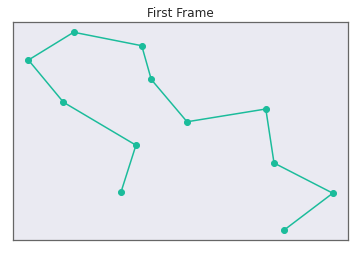

In [25]:
#TODO change to github link
paths = np.load('../data/paths.npz')['arr']
# plot the first point
plt.title('First Frame')
plt.plot(paths[0, :, 0], paths[0, :, 1], 'o-')
plt.xticks([])
plt.yticks([])
plt.show()

In [41]:
def center_com(paths):
    '''Align paths to COM at each frame'''
    coms = np.mean(paths, axis=-2, keepdims=True)
    return paths - coms
def center_point(paths):
    '''Align paths to particle 0'''
    return paths - paths[:, :1]
ccpaths = center_com(paths)
cppaths = center_point(paths)

To compare, we'll draw a sample of frames on top of one another to see the now translationally invariant incoordinates. 

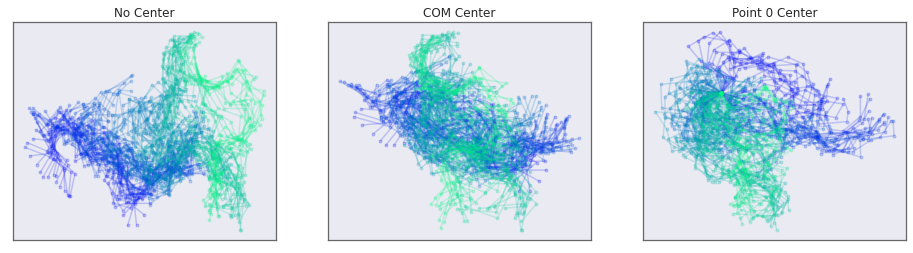

In [117]:
fig, axs = plt.subplots(ncols=3, squeeze=True, figsize=(16, 4))

axs[0].set_title('No Center')
axs[1].set_title('COM Center')
axs[2].set_title('Point 0 Center')
cmap = plt.get_cmap('winter')
for i in range(0, 2048, 16):
    axs[0].plot(paths[i, :, 0], paths[i, :, 1], '.-', alpha=0.2, color=cmap(i / 2048))
    axs[1].plot(ccpaths[i, :, 0], ccpaths[i, :, 1], '.-', alpha=0.2, color=cmap(i / 2048))
    axs[2].plot(cppaths[i, :, 0], cppaths[i, :, 1], '.-', alpha=0.2, color=cmap(i / 2048))
for i in range(3):
    axs[i].set_xticks([])
    axs[i].set_yticks([])

The color indicates time. You can see that having no alignment makes the spatial coordinates depend on time implicitly because the points drift over time. Both aligning to COM or point 0 removes this effect. The COM implicitly removes 2 degrees of freedom. Point 0 alignment makes point 0 have no variance (also remove degrees of freedom), which could affect how you design or interpret your model.

Now we will align by rotation. We need to define a unique rotation. A simple way is to choose 1 (or 2 in 3D) vectors that define our coordinate system directions. For example, we could choose that the vector from point 0 to point 1 defines the positive direction of the x-axis. A more sophisticated way is to find the principal axes of our points and align along these. For 2D, we only need to align to one of them. Again, this implicitly removes a degree of freedom. We will examine both. Computing principle axes requires an eigenvalue decomposition, so it's a bit more numerically intense {cite}`foote2000relation`. 

```{warning}
For all rotation alignment methods, you must have already centered the points. 
```

In [114]:
def make_2drot(angle):
    mats = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
    # swap so batch axis is first
    return np.swapaxes(mats, 0, -1)

def align_point(paths):
    '''Align to 0-1 vector assuming 2D data'''
    vecs = paths[:, 0, :] - paths[:, 1, :]
    # find angle to rotate so these are pointed towards pos x
    cur_angle = np.arctan2(vecs[:,1], vecs[:,0])
    rot_angle = -cur_angle
    rot_mat = make_2drot(rot_angle)
    # to mat mult at each frame
    return paths @ rot_mat

def find_principle_axis(points):
    '''Compute single principle axis for points'''
    inertia = points.T @ points
    evals, evecs = np.linalg.eigh(inertia)
    # get biggest eigenvalue
    order = np.argsort(evals)    
    return evecs[:, order[-1]]

def align_principle(paths):
    # someone should tell me how to vectorize this in numpy 
    vecs = [find_principle_axis(p) for p in paths]
    vecs = np.array(vecs)
    # find angle to rotate so these are pointed towards pos x
    cur_angle = np.arctan2(vecs[:,1], vecs[:,0])
    rot_angle = -cur_angle
    rot_mat = make_2drot(rot_angle)
    # to mat mult at each frame
    return paths @ rot_mat
    
appaths = align_point(cppaths)
apapaths = align_principle(ccpaths)

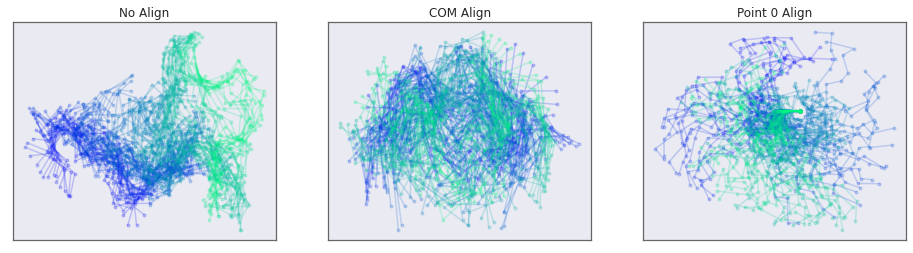

In [116]:
fig, axs = plt.subplots(ncols=3, squeeze=True, figsize=(16, 4))

axs[0].set_title('No Align')
axs[1].set_title('COM Align')
axs[2].set_title('Point 0 Align')
cmap = plt.get_cmap('winter')
for i in range(0, 2048, 16):
    axs[0].plot(paths[i, :, 0], paths[i, :, 1], '.-', alpha=0.2, color=cmap(i / 2048))    
    axs[1].plot(apapaths[i, :, 0], apapaths[i, :, 1], '.-', alpha=0.2, color=cmap(i / 2048))
    axs[2].plot(appaths[i, :, 0], appaths[i, :, 1], '.-', alpha=0.2, color=cmap(i / 2048))    
for i in range(3):
    axs[i].set_xticks([])
    axs[i].set_yticks([])

You can see how points far away on the chain from 0 have much more variance in the point 0 align, whereas the COM alignment looks better spread. Remember, to apply these methods you must do them to your both your training data and any prediction points. Thus, they should be viewed as part of your neural network.

Now which method is better? Aligning based on arbitrary points is indeed easier, but it creates an unusual new variance in your features. For example, let's see what happens if we make a small perturbation to one conformation. The code is hidden for simplicity. We try changing point 1, then point 0, then point 11 to see the effects of perturbations along the chain. 

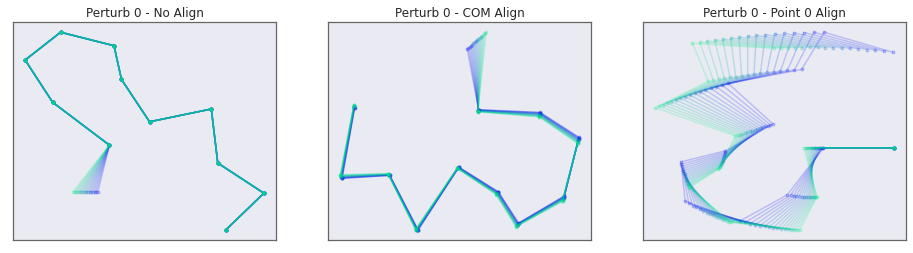

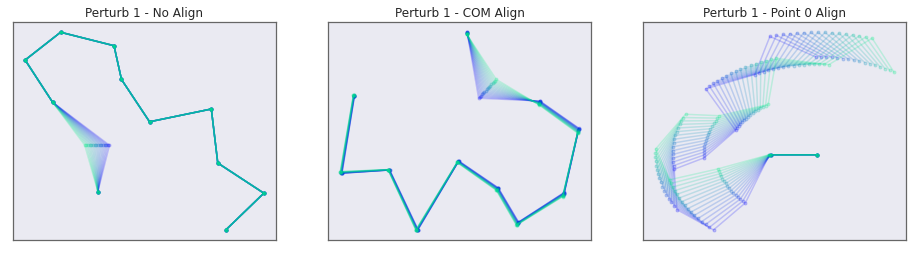

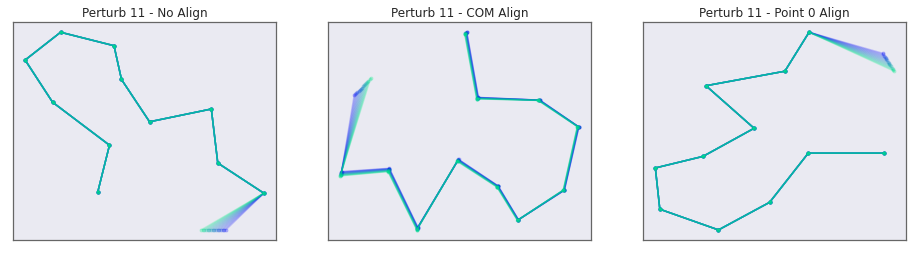

In [144]:
NP = 16
def perturb_paths(perturb_point):
    perturbation = np.zeros_like(paths[:NP])
    perturbation[:, perturb_point, 0] = np.linspace(0,0.2, NP)
    test_paths = paths[0:1] - perturbation

    # compute aligned trajs
    appaths = align_point(center_point(test_paths))
    apapaths = align_principle(center_com(test_paths))

    fig, axs = plt.subplots(ncols=3, squeeze=True, figsize=(16, 4))    
    axs[0].set_title(f'Perturb {perturb_point} - No Align')
    axs[1].set_title(f'Perturb {perturb_point} - COM Align')
    axs[2].set_title(f'Perturb {perturb_point} - Point 0 Align')
    cmap = plt.get_cmap('winter')
    for i in range(NP):
        axs[0].plot(test_paths[i, :, 0], test_paths[i, :, 1], '.-', alpha=0.2, color=cmap(i / NP))    
        axs[1].plot(apapaths[i, :, 0], apapaths[i, :, 1], '.-', alpha=0.2, color=cmap(i / NP))
        axs[2].plot(appaths[i, :, 0], appaths[i, :, 1], '.-', alpha=0.2, color=cmap(i / NP))    
    for i in range(3):
        axs[i].set_xticks([])
        axs[i].set_yticks([])
perturb_paths(0)
perturb_paths(1)
perturb_paths(11)

As you can see, perturbing one point alters all others after alignment. This makes these transformed features sensitive to noise, especially aligning to point 0 or 1. More importantly, this effect is uneven in the alignment to point 0. This can in-turn make training quite difficult. Of course, neural networks are universal approximators so in theory this should not matter. However, I expect that using the COM alignment approach will give better training because the network will not need to account for this unusual variance structure. 

```{margin}
The alignment changes due to small changes in input points is described by the Jacobian of our transform which measures how changes to one input dimension affects all output dimension.
```


### Using Unsupervised Methods for Alignment

There are many more methods for aligning trajectories. You could define one frame as the "reference" and find the translation and rotations that best align with that reference. This could give some interpretability to your rotation and translation alignment. Another option is to use PCA along the trajectory to find what are the dominant motions that describe the trajectory. The first two modes can be removed, removing enough degrees of freedom equivalent to translation and rotation variance. You can use many other dimension reduction methods to remove 6 dimensions. I do not understand the trade-offs of these, but remember that any way you choose should be able to accommodate new samples so that you can do inference. For example, t-SNE can reduce dimensions but you have to recompute your t-SNE if you have a new data-point. That would require re-training when you want to do inference and make the network useless.

## Distance Features

One more topic on parsing data is treating distances. As we saw above, pairwise distance is a wise transformation because it is translation and rotation invariant. However, we may want to sometimes transform this further. One obvious choice is to use $1 / r$ as the input to our neural network. This is because most properties of atoms (and thus molecules) are affected by their closest nearby atoms. An oxygen nearby a carbon is much more important than an oxygen that is 100 nanometers away. Choosing $1 / r$ as an input makes it easier for a neural network to train because it encodes this physical insight about local interactions being the most important. Of course, a neural network could learn to turn $r$ into $1/r$ because they are universal approximators. Yet this approach means we do not need to waste training data and weights on learning to change $r$ into $1 / r$.

Another detail on distances is that we often want to "featurize" them; we'd like to go from one a single number like $r = 3.2$ to a vector of reals. Why? Well that's just how neural networks learn. Hidden-layers need to have more than 1 dimension to be expressive enough to model any function. This seems like an obvious point though: if you used $r$ in a neural network it would obviously get larger as it goes through hidden layers. However, there are a few "standard" ways that people like to do this process. There are valid reasons, like making it smoothly differentiable, that you might choose one of these special "featurizing" functions.

### Repeating

The first approach is to just repeat $r$ up to the desired hidden dimension. This is representable as a dense neural network with no activation. Repeating $r$ is just sometimes mentioned as a way to featurize distances. 

### Binning

As explored in Gilmer et al. {cite}`gilmer2017neural` and others, you can bin your distances to be a one-hot vector. Essentially, you histogram $r$ into fixed bins so that you only have one bin being "hot". Each bin will represent a segment of positions (e.g., 4.5-5.0). This has discontinuous derivatives wrt distance and rarely used, though discussed frequently. 

### Radial Basis Functions

I've seen these used in a number of papers and I'm not sure who to credit for it. Radial basis functions use the following equation:

\begin{equation}
    e_i = \exp\left[{-\left(r - d_i\right)^2 / w}\right]
\end{equation}

where $d_i$ is an equally spaced vector of distances (e.g., $[1, 2, 3, 4]$) and $w$ is a trainable (or hyper) parameter. This computes a Gaussian kernel between $r$ and all distances $d_i$. What is nice about this expression is that has smooth well-behaved derivatives with respect to $r$ and no trainable parameters. You can represent this with a dense layer and a softmax activation, but that is slightly more complex and has trainable parameters. 


### Sub NN

Another strategy used in Gilmer et al. {cite}`gilmer2017neural` is to just put your distances through a series of dense layers prior to get features. For example, if you're going to use the distance in a graph neural network you could run it through three dense layers first to get a larger feature dimension. Remember that repeating and radial basis functions are equivalent to dense layers (depending on activation), so this strategy can be a simple solution to the above choice. 

## Relevant Videos

### Equivariant Networks

<iframe width="560" height="315" src="https://www.youtube-nocookie.com/embed/8CF8Grb_brE" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

## Cited References

```{bibliography} references.bib
```